Questão 01: A partir de determinada imagem, será produzido, em nível de cinza:
• Escolha cenários com bordas presentes;
• Degrade a imagem com ruído “sal e pimenta”;
• Aplique as diversas máscaras de filtragem com preservação de bordas:
    o Kuwahara et al. (1976);
    o Tomita e Tsuji (1977);
    o Nagao e Matsuyama (1979);
    o Somboonkaew et al. (1999);
    o Adelmann (1999).
• E compare com algum método tradicional.

In [3]:
import random
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def add_ruido(img):

    linha, coluna = img.shape

    numero_pixels = random.randint(300, 100000)
    for i in range(numero_pixels):

        coordenada_y = random.randint(0, linha - 1)
        coordenada_x = random.randint(0, coluna - 1)

        img[coordenada_y][coordenada_x] = 255

    numero_pixels = random.randint(300, 100000)
    for i in range(numero_pixels):

        coordenada_y = random.randint(0, linha - 1)
        coordenada_x = random.randint(0, coluna - 1)

        img[coordenada_y][coordenada_x] = 0

    return img

Após a adição do ruido "Sal e Pimenta", agora podemos trabalhar com essa nova imagem, logo abaixo é apresentado e imagem original ao lado da imagem com ruido.

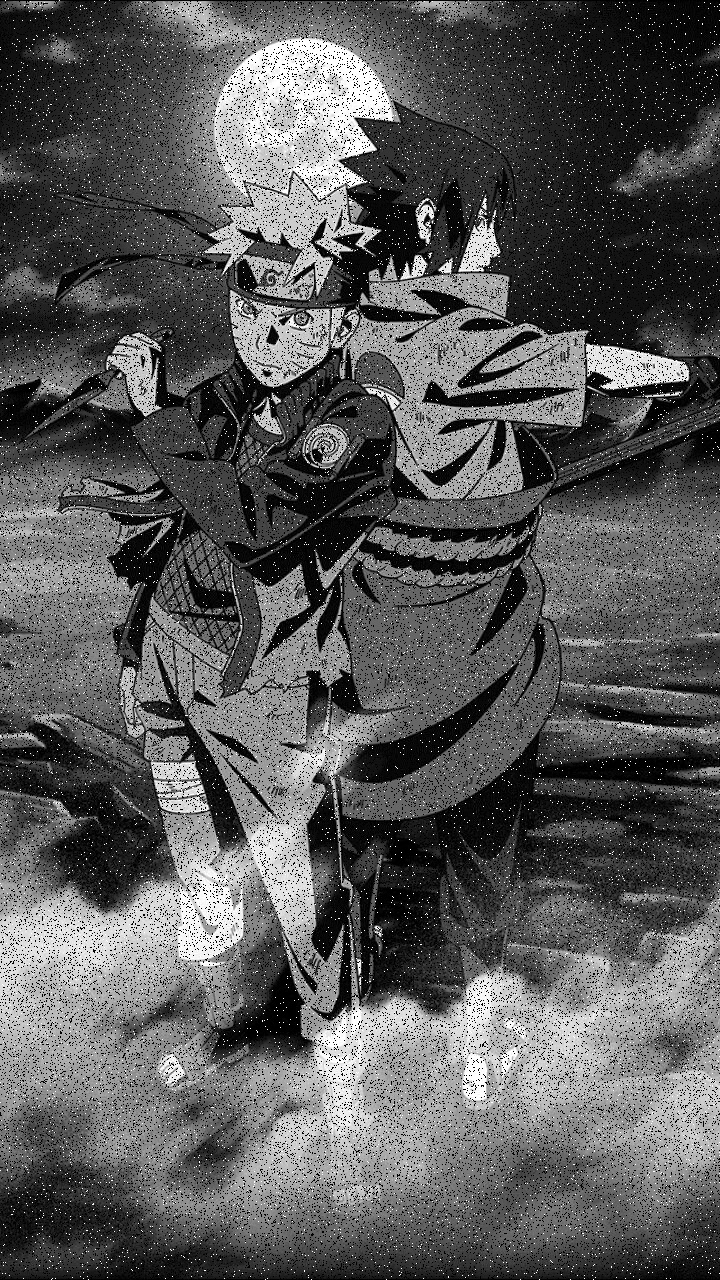

In [4]:
img = cv2.imread('naru_pretoEbranco.jpg', cv2.IMREAD_GRAYSCALE)

cv2.imwrite('salEpimenta_naru.jpg', add_ruido(img))

# im1 = Image.open('naru_pretoEbranco.jpg')
# im1

im2 = Image.open('salEpimenta_naru.jpg')
im2

# res1 = np.hstack((im1, im2))
# cv2.imwrite('salEpimenta_naru_lado_lado.jpg', res1)

# res2 = Image.open('salEpimenta_naru_lado_lado.jpg')
# res2

Agora podemos trabalhar com essa nova imagem, primeiro vamos aplicar a filtragem de Kuwahara.
O filtro de Kuwahara pode ser definido como um filtro não linear de suavização que não compromete a nitidez da imagem ou as posições das bordas, sendo reconhecido tradicionalmente por este segundo aspecto.

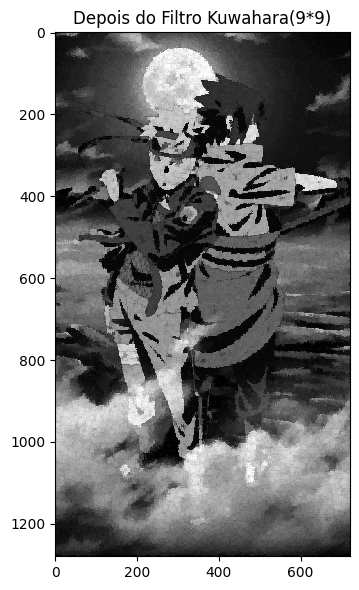

In [22]:
from scipy.signal import convolve2d
from skimage import io

def Kuwahara(original, winsize):
    image = original.astype(np.float64)
    # make sure window size is correct
    if winsize %4 != 1:
        raise Exception ("Invalid winsize %s: winsize must follow formula: w = 4*n+1." %winsize)
        
    #Build subwindows
    tmpAvgKerRow = np.hstack((np.ones((1,(winsize-1)//2+1)),np.zeros((1,(winsize-1)//2))))
    tmpPadder = np.zeros((1,winsize))
    tmpavgker = np.tile(tmpAvgKerRow, ((winsize-1)//2+1,1))
    tmpavgker = np.vstack((tmpavgker, np.tile(tmpPadder, ((winsize-1)//2,1))))
    tmpavgker = tmpavgker/np.sum(tmpavgker)
    
    # tmpavgker is a 'north-west' subwindow (marked as 'a' above)
    # we build a vector of convolution kernels for computing average and
    # variance
    avgker = np.empty((4,winsize,winsize)) # make an empty vector of arrays
    avgker[0] = tmpavgker # North-west (a)
    avgker[1] = np.fliplr(tmpavgker) # North-east (b)
    avgker[2] = np.flipud(tmpavgker) # South-west (c)
    avgker[3] = np.fliplr(avgker[2]) # South-east (d)
    
    # Create a pixel-by-pixel square of the image
    squaredImg = image**2 
    
    # preallocate these arrays to make it apparently %15 faster
    avgs = np.zeros([4, image.shape[0],image.shape[1]])
    stddevs = avgs.copy()
    
    # Calculation of averages and variances on subwindows
    for k in range(4):
        # mean on subwindow
        avgs[k] = convolve2d(image, avgker[k],mode='same')
        # mean of squares on subwindow
        stddevs[k] = convolve2d(squaredImg, avgker[k],mode='same')
        # variance on subwindow
        stddevs[k] = stddevs[k]-avgs[k]**2
    # Choice of index with minimum variance
    indices = np.argmin(stddevs,0) # returns index of subwindow with smallest variance
    
    # Building the filtered image (with nested for loops)
    filtered = np.zeros(original.shape)
    for row in range(original.shape[0]):
        for col in range(original.shape[1]):
            filtered[row,col] = avgs[indices[row,col], row,col]
            
    filtered=filtered.astype(np.uint8)
    return filtered.astype(np.uint8)

img_ruido = np.array(Image.open('salEpimenta_naru.jpg'))
area = 9
imgNormalKuwahara = Kuwahara(img_ruido, area)

plt.figure(figsize=(15,6)) 
plt.title("Depois do Filtro Kuwahara(9*9)")
io.imshow(imgNormalKuwahara/255)
plt.show()
